In [2]:
library(adaptMCMC)
library(coda)
library(extRemes)
library(dplyr)
library(ggplot2)

      year          month             day             hour         sealevel   
 Min.   :1904   Min.   : 1.000   Min.   : 1.00   Min.   : 0.0   Min.   :-624  
 1st Qu.:1932   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.: 5.0   1st Qu.:1128  
 Median :1959   Median : 7.000   Median :16.00   Median :11.0   Median :1341  
 Mean   :1960   Mean   : 6.513   Mean   :15.73   Mean   :11.5   Mean   :1339  
 3rd Qu.:1989   3rd Qu.:10.000   3rd Qu.:23.00   3rd Qu.:18.0   3rd Qu.:1554  
 Max.   :2016   Max.   :12.000   Max.   :31.00   Max.   :23.0   Max.   :4190  

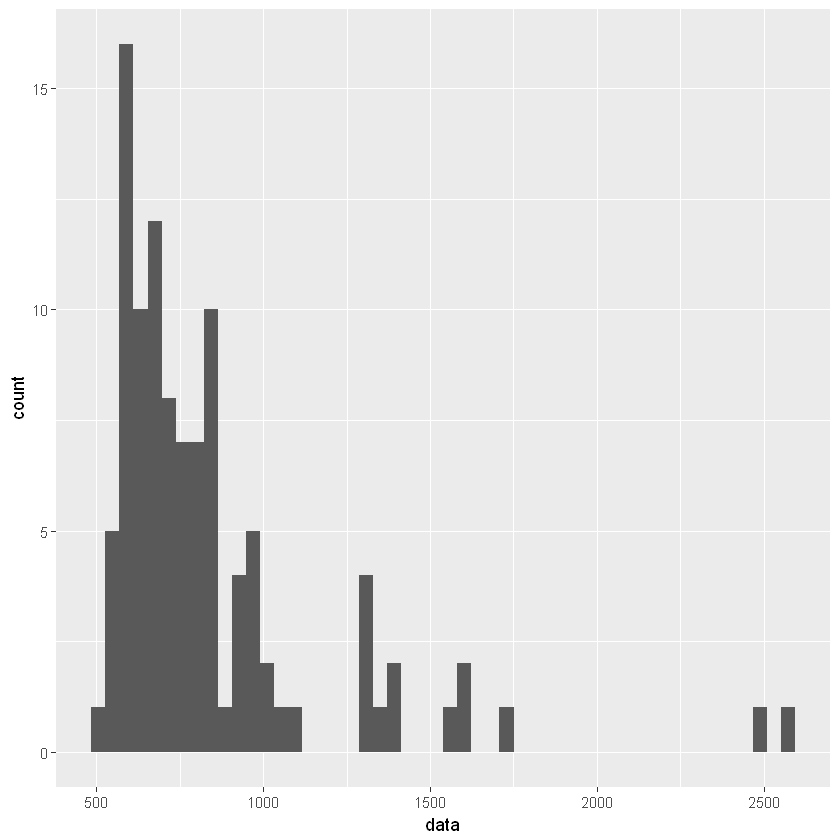

In [12]:
df = read.csv('Galveston.csv', header=FALSE, col.names=c('year', 'month', 'day', 'hour', 'sealevel'))
fill_in = min(df$sealevel)
df = filter(df, df$sealevel != fill_in)
summary(df)
data_meas = c()
for (i in seq(1904, 2016)){
    nsl = length(filter(df, df$year==i)$sealevel)
    if (nsl/(365*24) >= 0.9){
        data_meas = c(data_meas, max(filter(df, df$year==i)$sealevel)-mean(filter(df, df$year==i)$sealevel))
    }
}

data_meas.df = data.frame(data=data_meas)
ggplot()+
        geom_histogram(data=data_meas.df, aes(x=data), bins=50)

In [40]:
# GEV

loglikelihood.gev = function(params, data){
    mu = params[1]
    sigma = params[2]
    xi = params[3]
    return (sum(devd(data, loc=mu, scale=sigma, shape=xi, log=TRUE, type='GEV')))
}

logprior.gev = function(params){
    mu = params[1]
    sigma = params[2]
    xi = params[3]
    mu_logpdf = dunif(x=mu, min=0, max=100000, log=TRUE)
    xi_logpdf = dnorm(x=xi, mean=0, sd=1000, log=TRUE)
    if (sigma >= 10000 | sigma <= 0){
        return (-Inf)
    }
    return (mu_logpdf+xi_logpdf+log(1/10000))
}

logpost.gev = function(params, data){
    lprior = logprior.gev(params)
    if (is.infinite(lprior)){
        return (-Inf)
    }
    ll = loglikelihood.gev(params, data)
    return (ll+lprior)
}

In [41]:
# Log-normal

loglikelihood.lnorm = function(params, data){
    mu = params[1]
    sigma = params[2]
    return (sum(dlnorm(data, mu, sigma, log=TRUE)))
}

logprior.lnorm = function(params){
    mu = params[1]
    sigma = params[2]
    mu_logpdf = dunif(x=mu, min=0, max=100000, log=TRUE)
    if (sigma >= 100 | sigma <= 0){
        return (-Inf)
    }
    return (mu_logpdf+log(1/100))
}

logpost.lnorm = function(params, data){
    lprior = logprior.lnorm(params)
    if (is.infinite(lprior)){
        return (-Inf)
    }
    ll = loglikelihood.lnorm(params, data)
    return (ll+lprior)
}

In [44]:
# Gumbel

loglikelihood.gumbel = function(params, data){
    mu = params[1]
    sigma = params[2]
    return (sum(devd(data, mu, sigma, log=TRUE)))
}

logprior.gumbel = function(params){
    mu = params[1]
    sigma = params[2]
    mu_logpdf = dunif(x=mu, min=0, max=100000, log=TRUE)
    if (sigma >= 10000 | sigma <= 0){
        return (-Inf)
    }
    return (mu_logpdf+log(1/10000))
}

logpost.gumbel = function(params, data){
    lprior = logprior.gumbel(params)
    if (is.infinite(lprior)){
        return (-Inf)
    }
    ll = loglikelihood.gumbel(params, data)
    return (ll+lprior)
}

In [57]:
# Exponential

loglikelihood.exp = function(params, data){
    return (sum(dexp(data, params, log=TRUE)))
}

logprior.exp = function(params){
    lambda_logpdf = dunif(x=params, min=0, max=10000000, log=TRUE)
    return (lambda_logpdf)
}

logpost.exp = function(params, data){
    lprior = logprior.exp(params)
    if (is.infinite(lprior)){
        return (-Inf)
    }
    ll = loglikelihood.exp(params, data)
    return (ll+lprior)
}

In [70]:
niter = 30000
nchain = 3

mcmc.chains.raw.gev = mcmc.stationary.parallel <- MCMC.parallel(p=logpost.gev,
                                                        n=niter,
                                                        init=c(400, 200, 0),
                                                        n.chain=nchain,
                                                        adapt=TRUE,
                                                        acc.rate=0.40,
                                                        list=TRUE,
                                                        n.cpu=2,
                                                        n.start=1000,
                                                        data = data_meas,
                                                        packages = 'extRemes'
                                                       )
mcmc.chains.gev = convert.to.coda(mcmc.chains.raw.gev)



mcmc.chains.raw.lnorm = mcmc.stationary.parallel <- MCMC.parallel(p=logpost.lnorm,
                                                        n=niter,
                                                        init=c(6,1),
                                                        n.chain=nchain,
                                                        adapt=TRUE,
                                                        acc.rate=0.40,
                                                        list=TRUE,
                                                        n.cpu=2,
                                                        n.start=1000,
                                                        data = data_meas,
                                                        packages = 'extRemes'
                                                       )
mcmc.chains.lnorm = convert.to.coda(mcmc.chains.raw.lnorm)



mcmc.chains.raw.gumbel = mcmc.stationary.parallel <- MCMC.parallel(p=logpost.gumbel,
                                                        n=niter,
                                                        init=c(400,100),
                                                        n.chain=nchain,
                                                        adapt=TRUE,
                                                        acc.rate=0.40,
                                                        list=TRUE,
                                                        n.cpu=2,
                                                        n.start=1000,
                                                        data = data_meas,
                                                        packages = 'extRemes'
                                                       )
mcmc.chains.gumbel = convert.to.coda(mcmc.chains.raw.gumbel)



mcmc.chains.raw.exp = mcmc.stationary.parallel <- MCMC.parallel(p=logpost.exp,
                                                        n=niter,
                                                        init=0.002,
                                                        n.chain=nchain,
                                                        adapt=TRUE,
                                                        acc.rate=0.40,
                                                        list=TRUE,
                                                        n.cpu=2,
                                                        n.start=1000,
                                                        data = data_meas,
                                                        packages = 'extRemes'
                                                       )
mcmc.chains.exp = convert.to.coda(mcmc.chains.raw.exp)

[1] "Cluster stopped."
[1] "Cluster stopped."
[1] "Cluster stopped."
[1] "Cluster stopped."


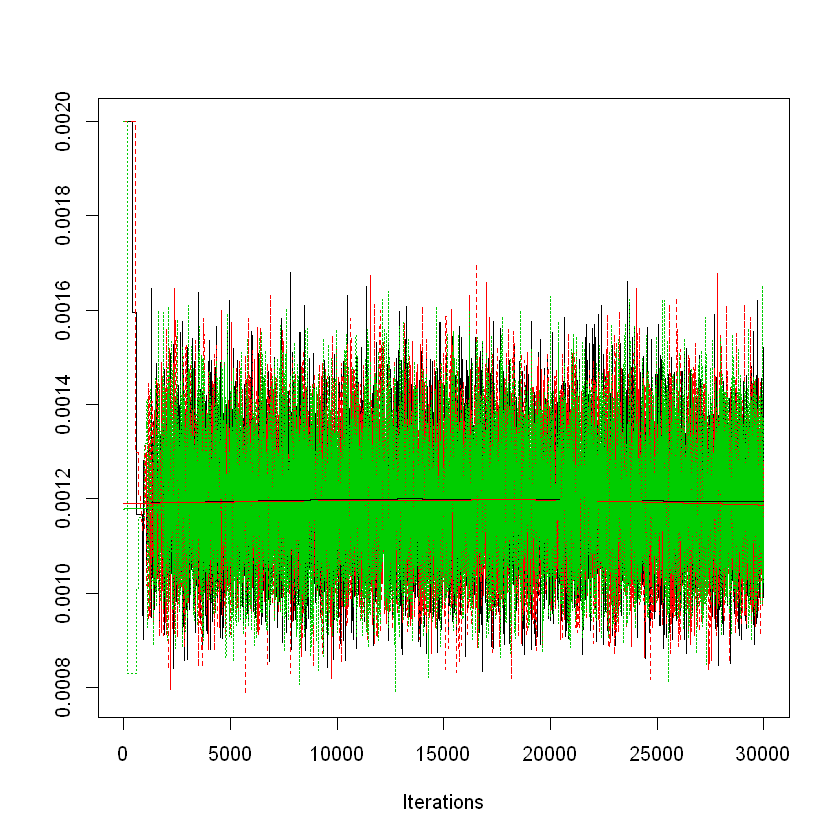

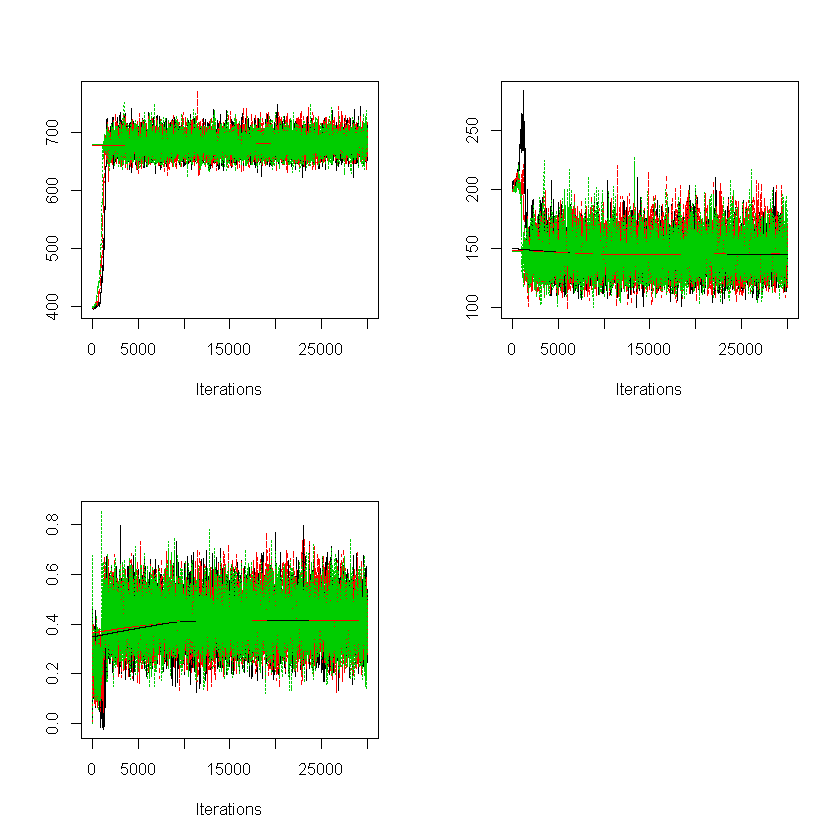

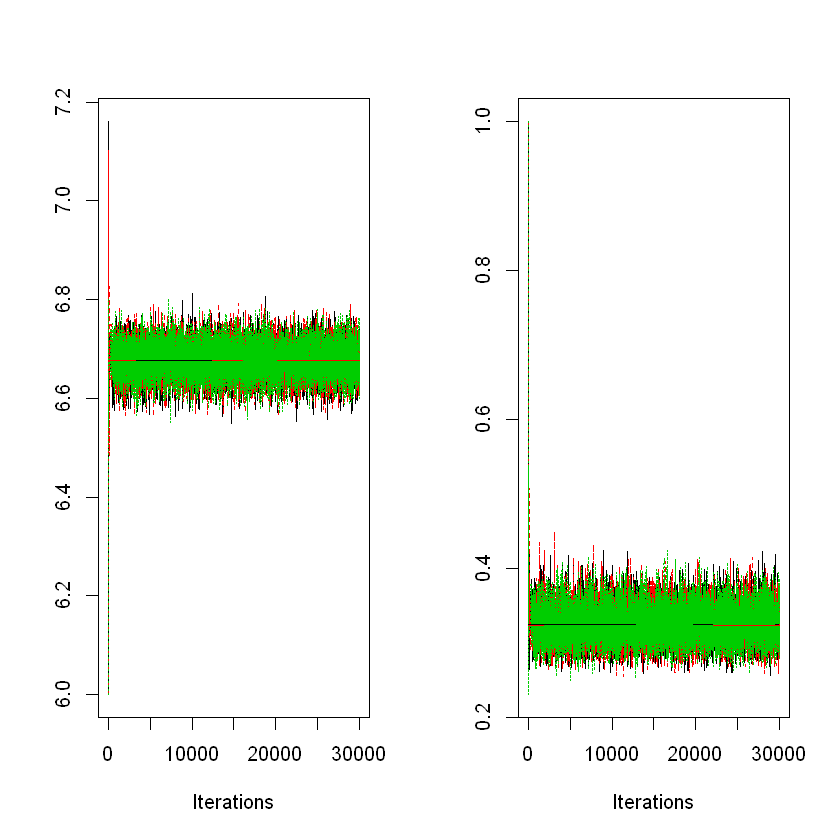

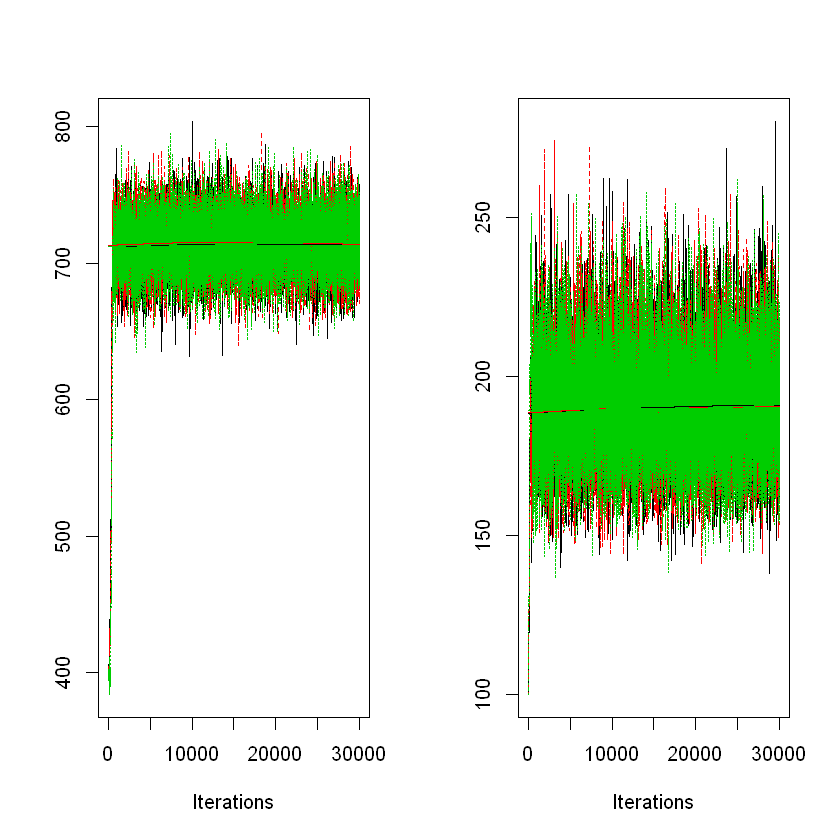

In [75]:
plot(mcmc.chains.exp, density=FALSE)
plot(mcmc.chains.gev, density=FALSE)
plot(mcmc.chains.lnorm, density=FALSE)
plot(mcmc.chains.gumbel, density=FALSE)

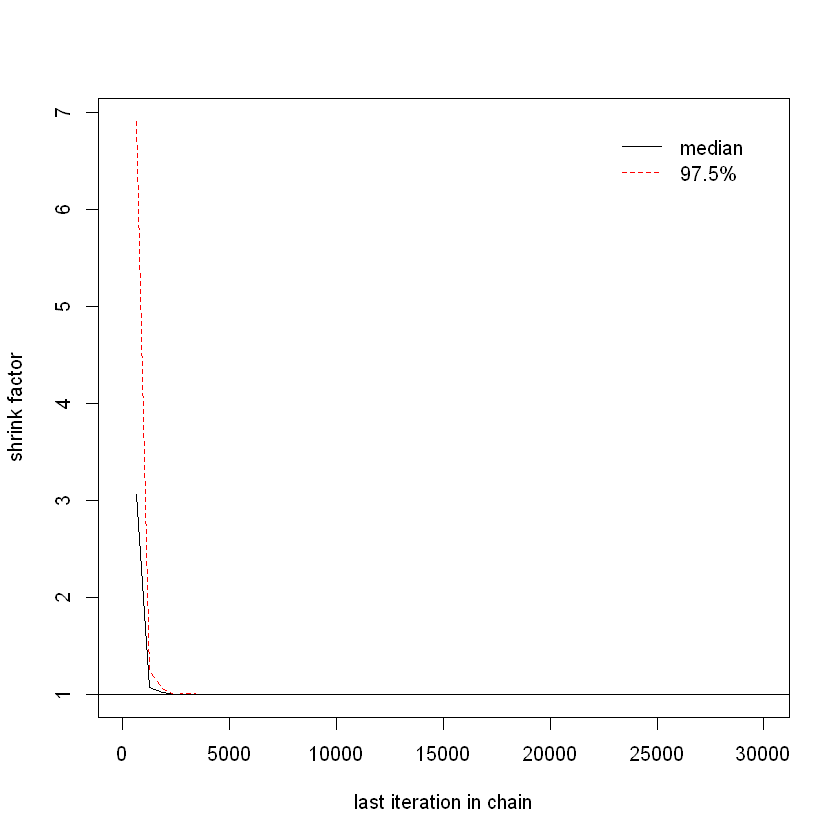

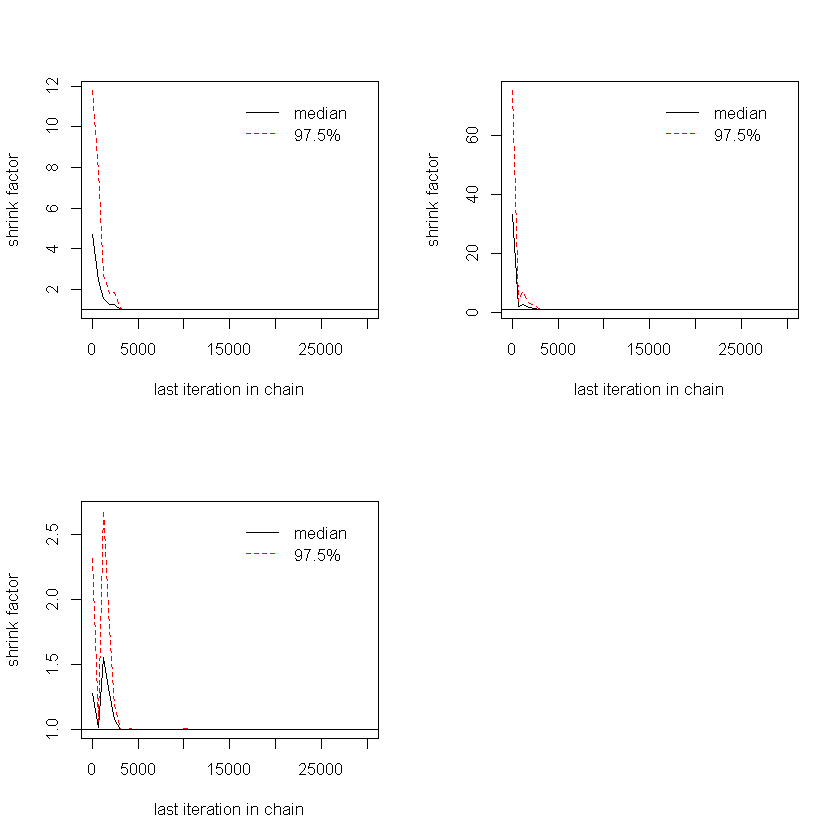

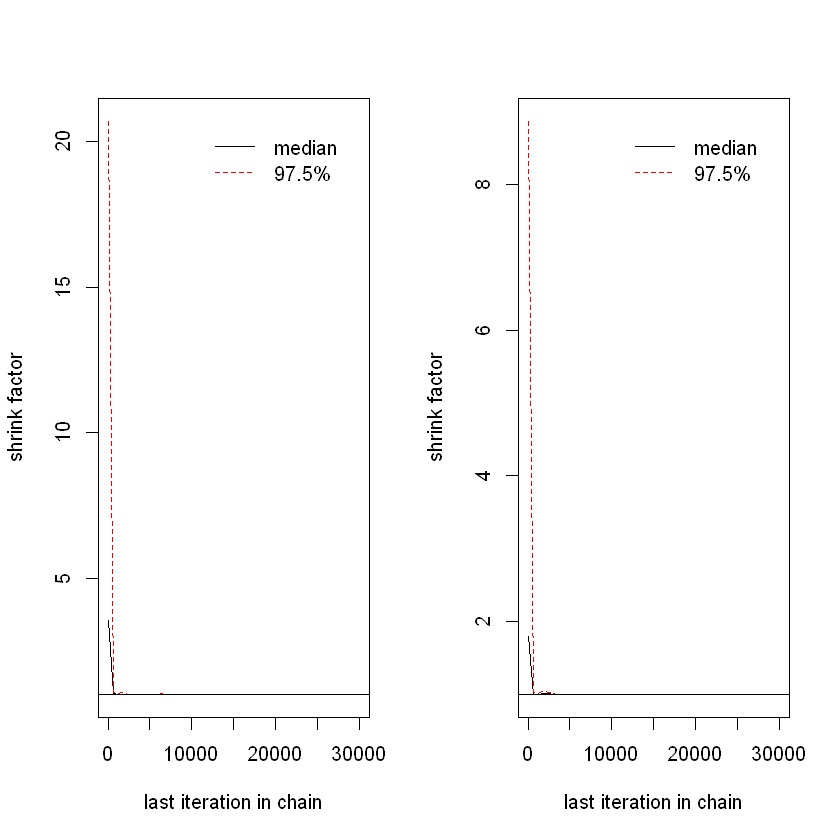

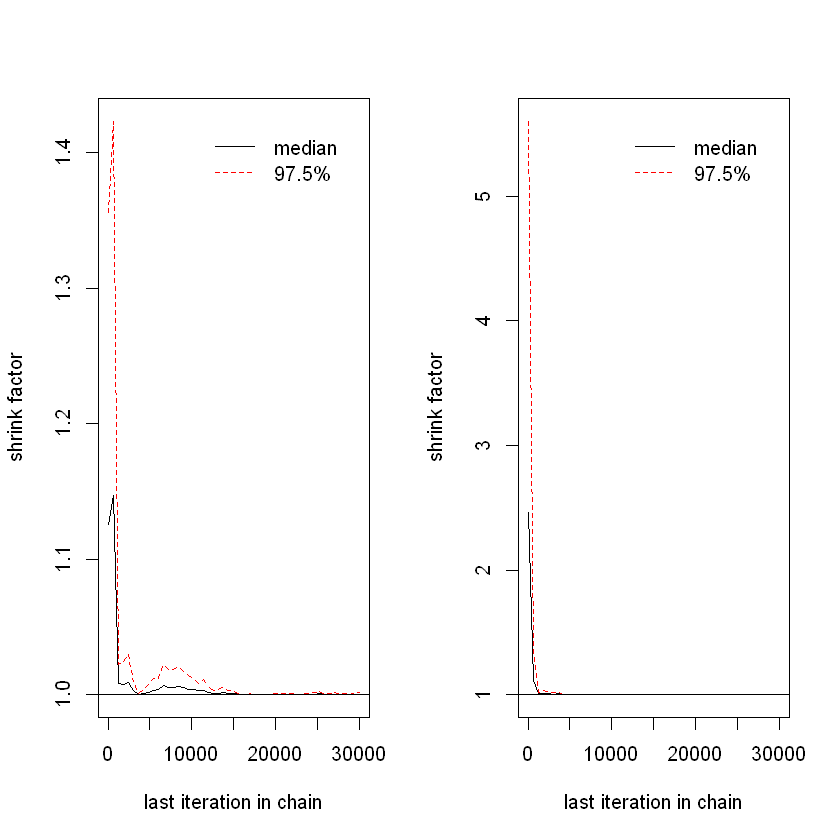

In [93]:
gelman.plot(mcmc.chains.exp)
gelman.plot(mcmc.chains.gev)
gelman.plot(mcmc.chains.lnorm)
gelman.plot(mcmc.chains.gumbel)

In [145]:
gumbel.burn = mcmc.list(list(as.mcmc(mcmc.chains.gumbel[[1]][5000:niter,]),
                                      as.mcmc(mcmc.chains.gumbel[[2]][5000:niter,]),
                                      as.mcmc(mcmc.chains.gumbel[[3]][5000:niter,])))

lnorm.burn = mcmc.list(list(as.mcmc(mcmc.chains.lnorm[[1]][5000:niter,]),
                                      as.mcmc(mcmc.chains.lnorm[[2]][5000:niter,]),
                                      as.mcmc(mcmc.chains.lnorm[[3]][5000:niter,])))


gev.burn  = mcmc.list(list(as.mcmc(mcmc.chains.gev[[1]][5000:niter,]),
                                      as.mcmc(mcmc.chains.gev[[2]][5000:niter,]),
                                      as.mcmc(mcmc.chains.gev[[3]][5000:niter,])))

exp.burn = mcmc.list(list(as.mcmc(mcmc.chains.exp[[1]][5000:niter,]),
                                      as.mcmc(mcmc.chains.exp[[2]][5000:niter,]),
                                      as.mcmc(mcmc.chains.exp[[3]][5000:niter,])))

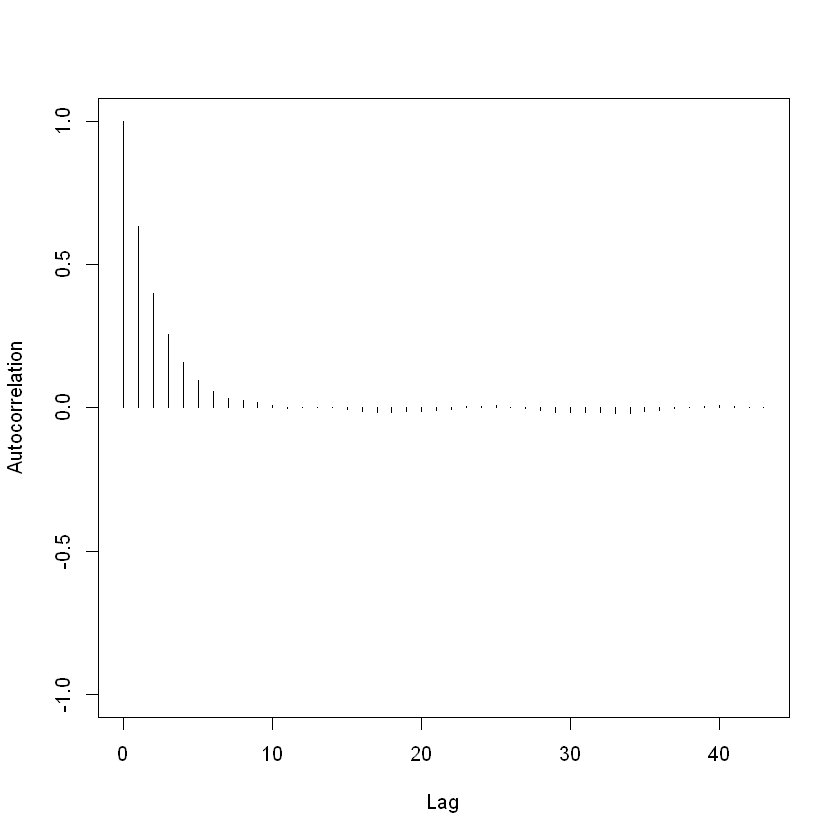

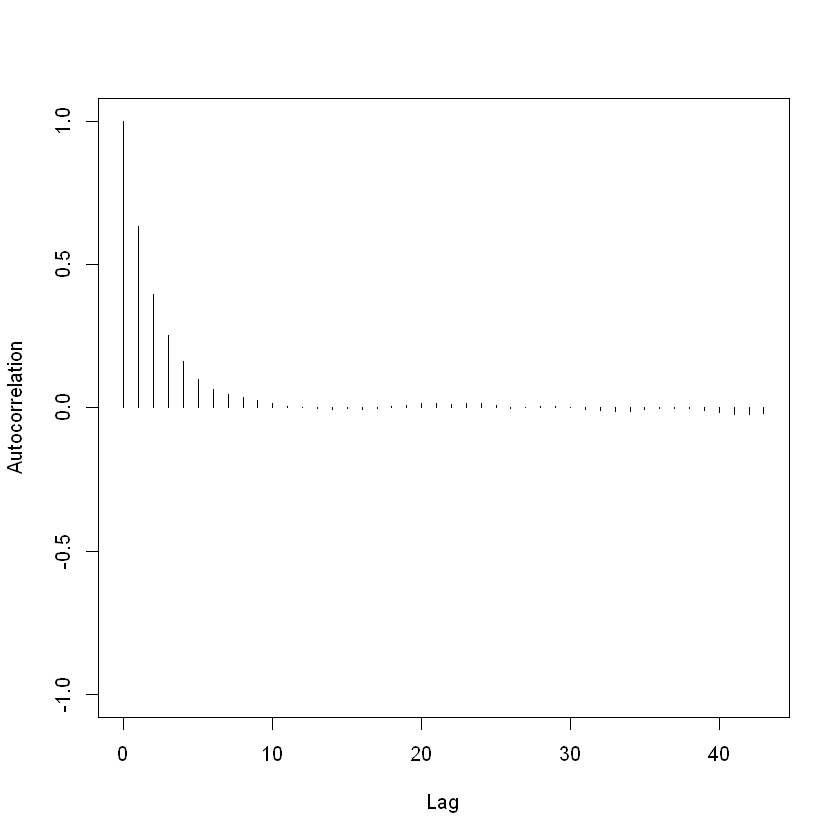

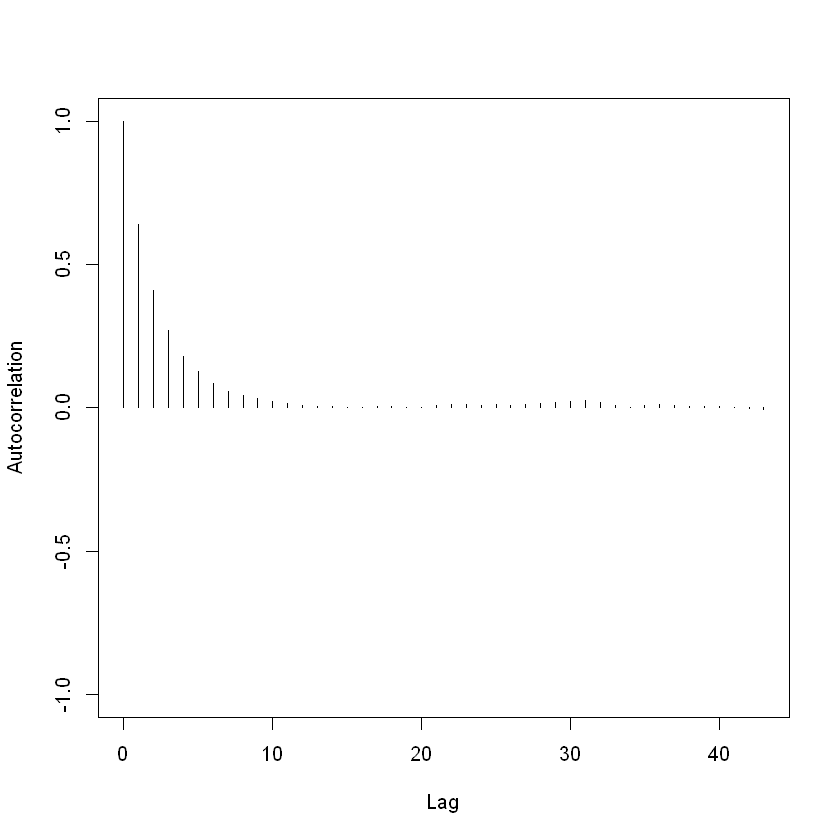

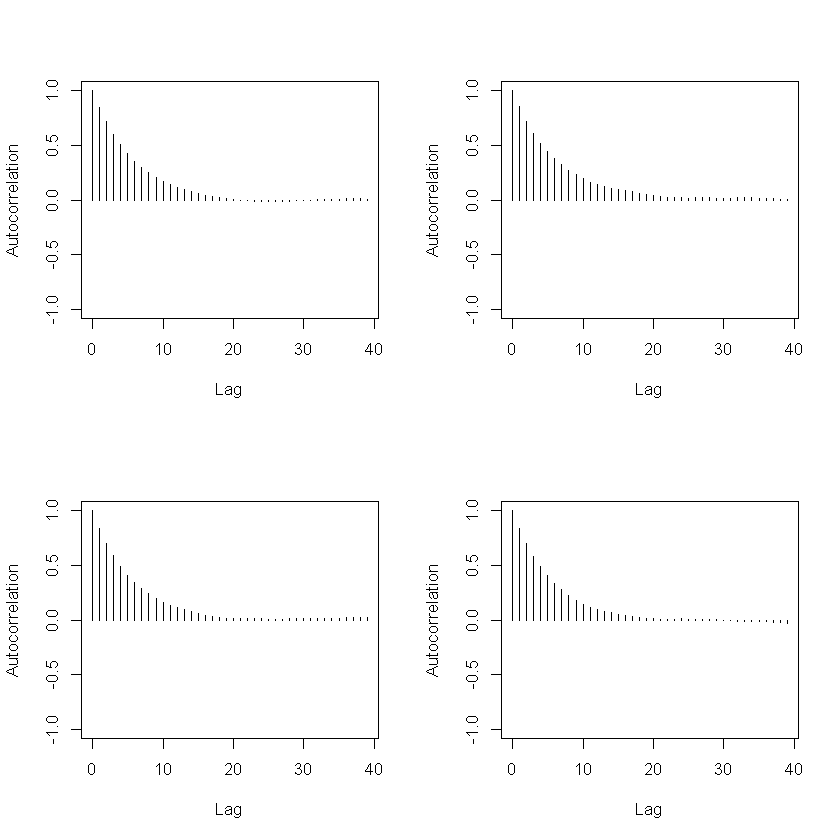

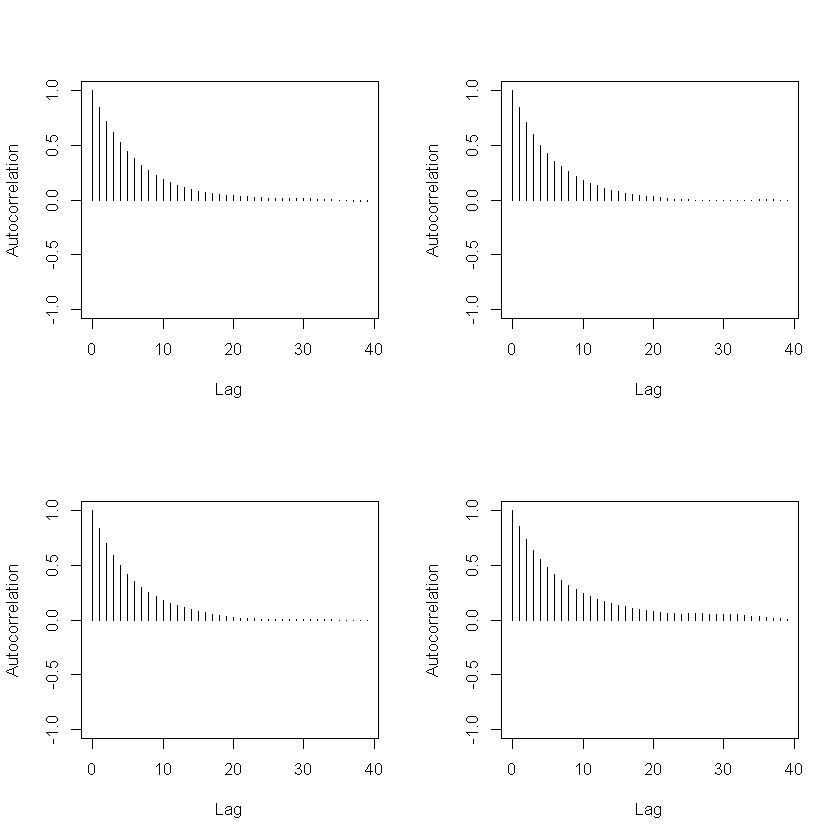

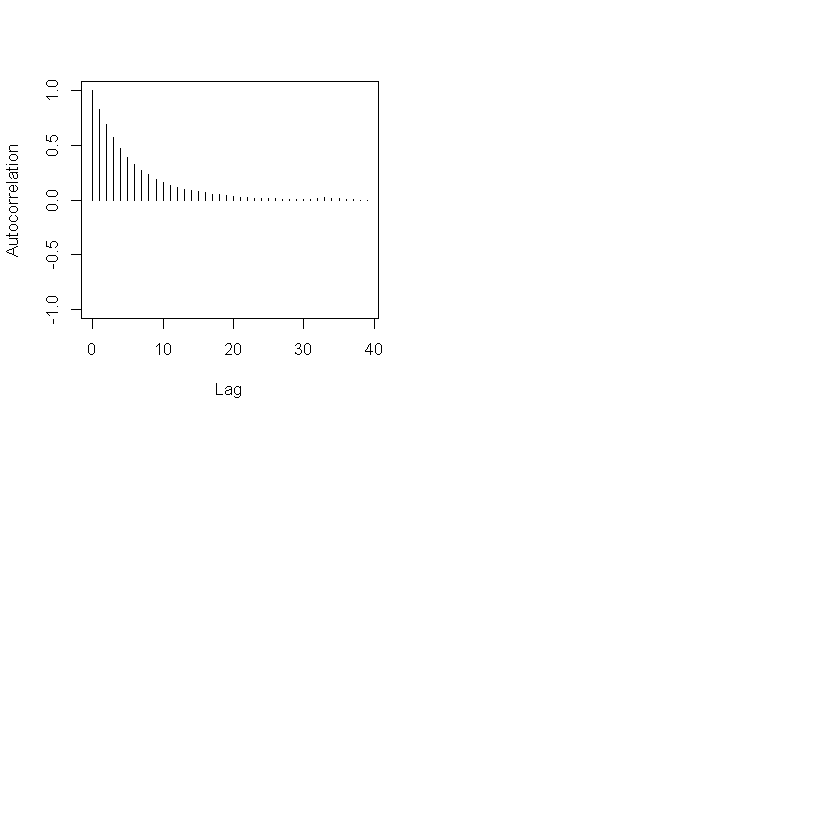

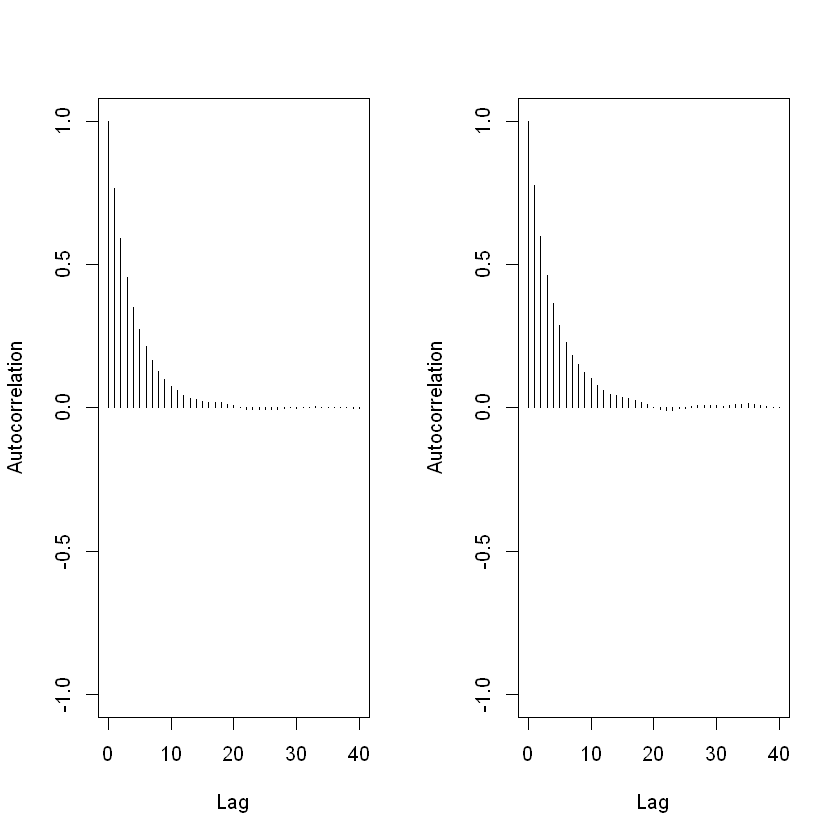

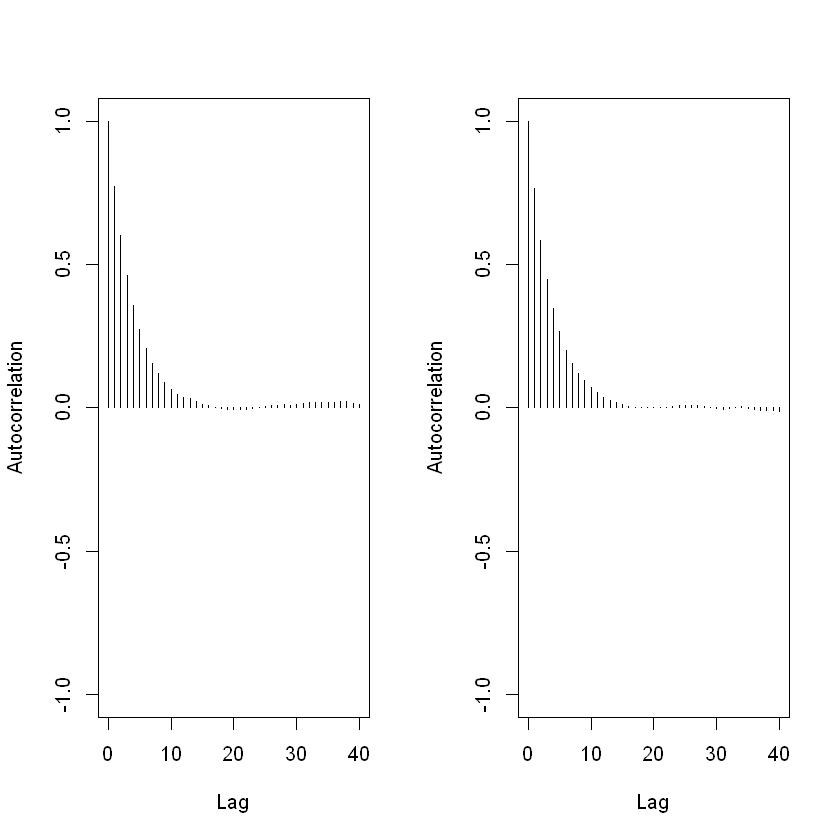

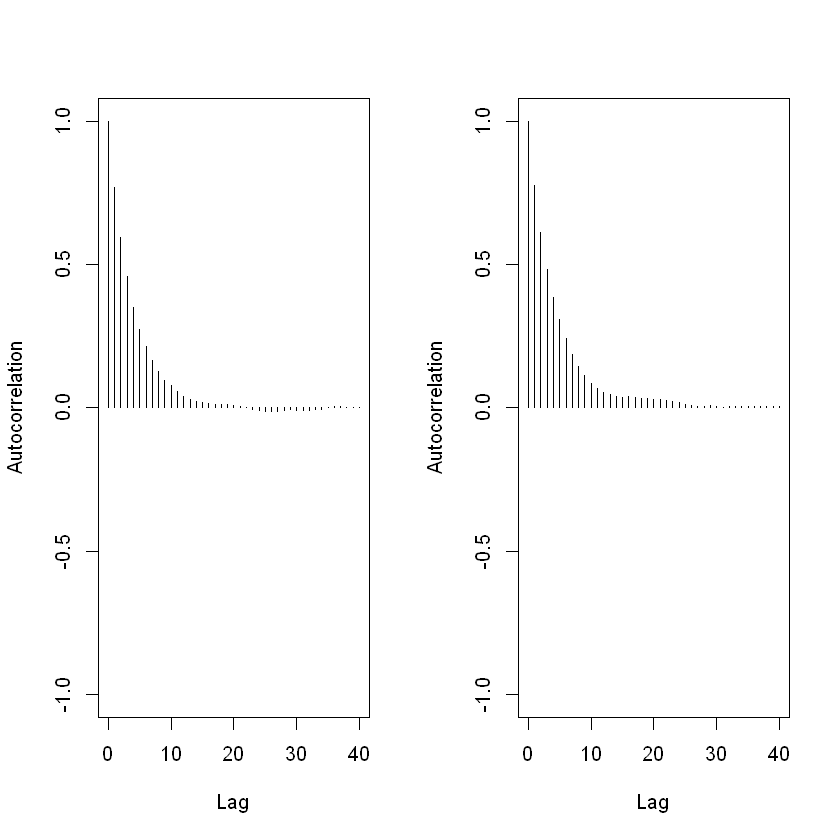

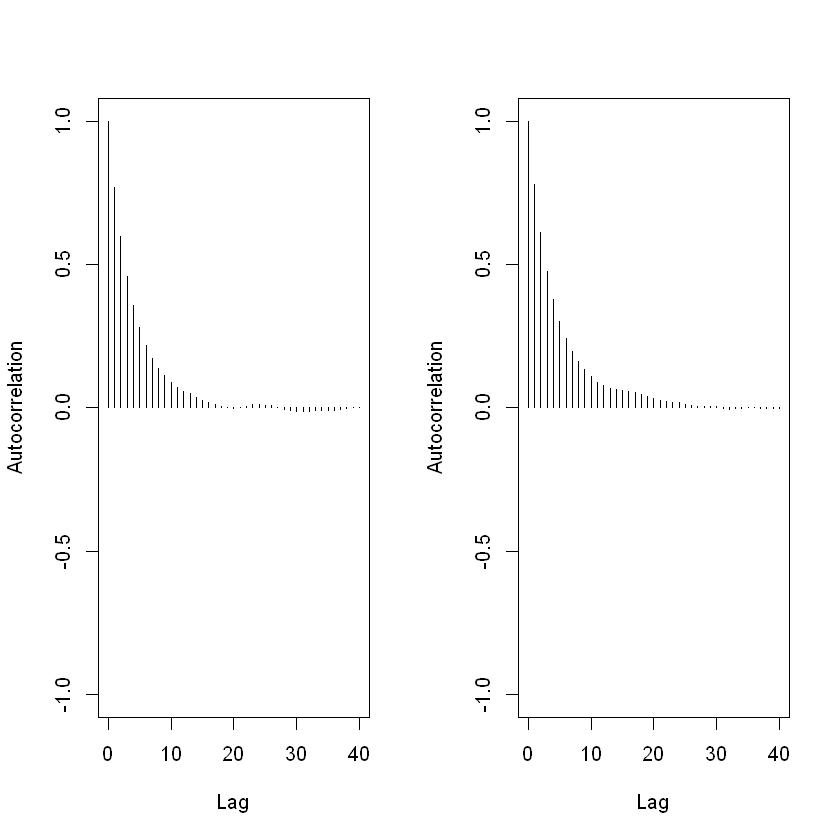

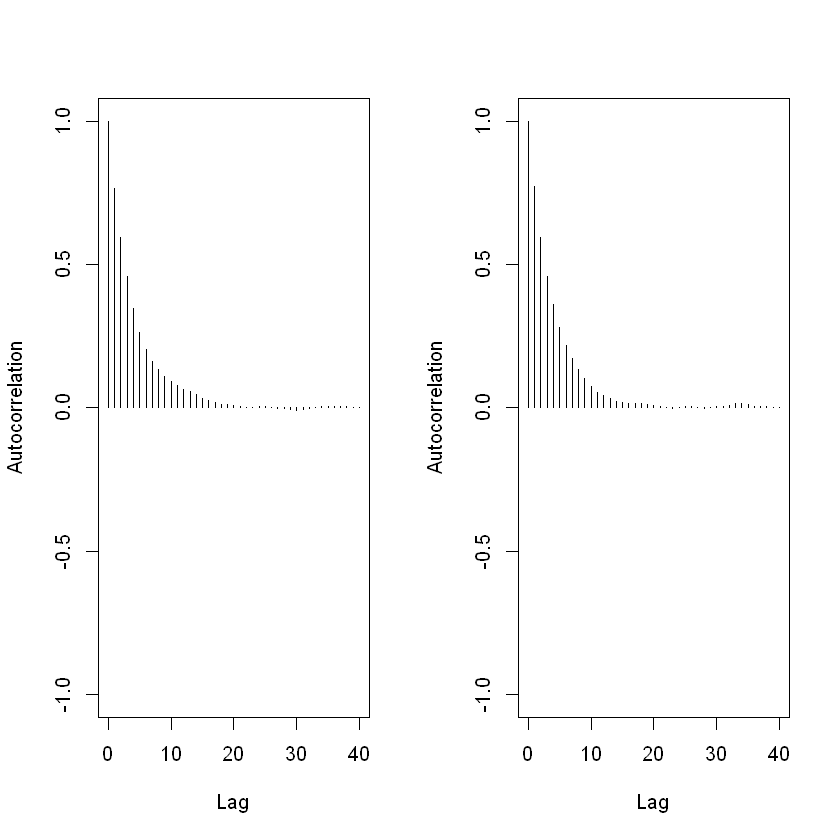

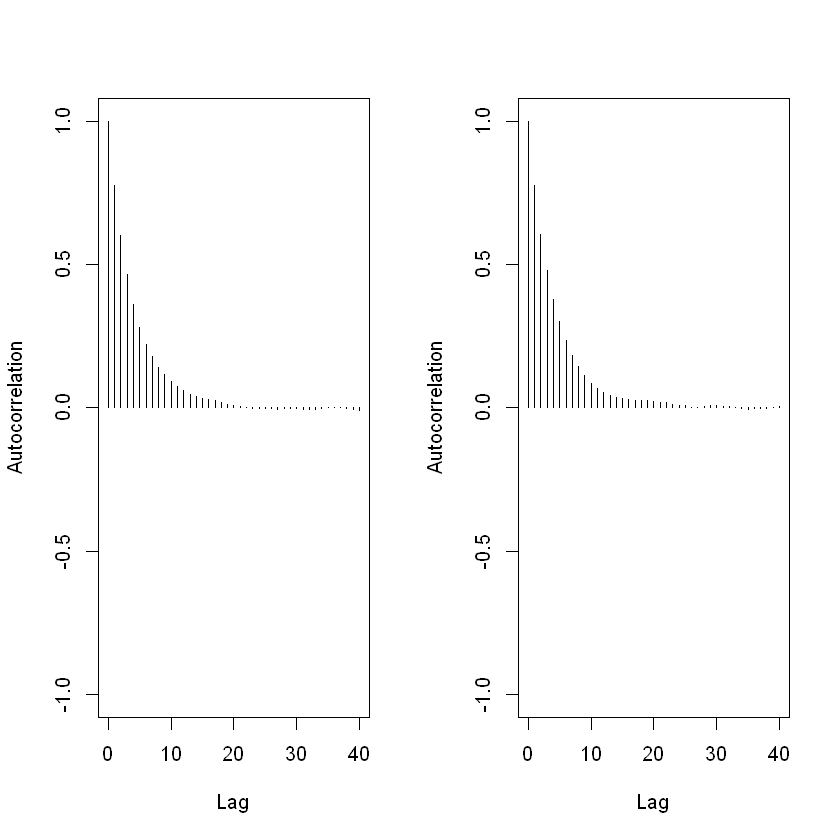

In [181]:
autocorr.plot(exp.burn)
autocorr.plot(gev.burn)
autocorr.plot(lnorm.burn)
autocorr.plot(gumbel.burn)

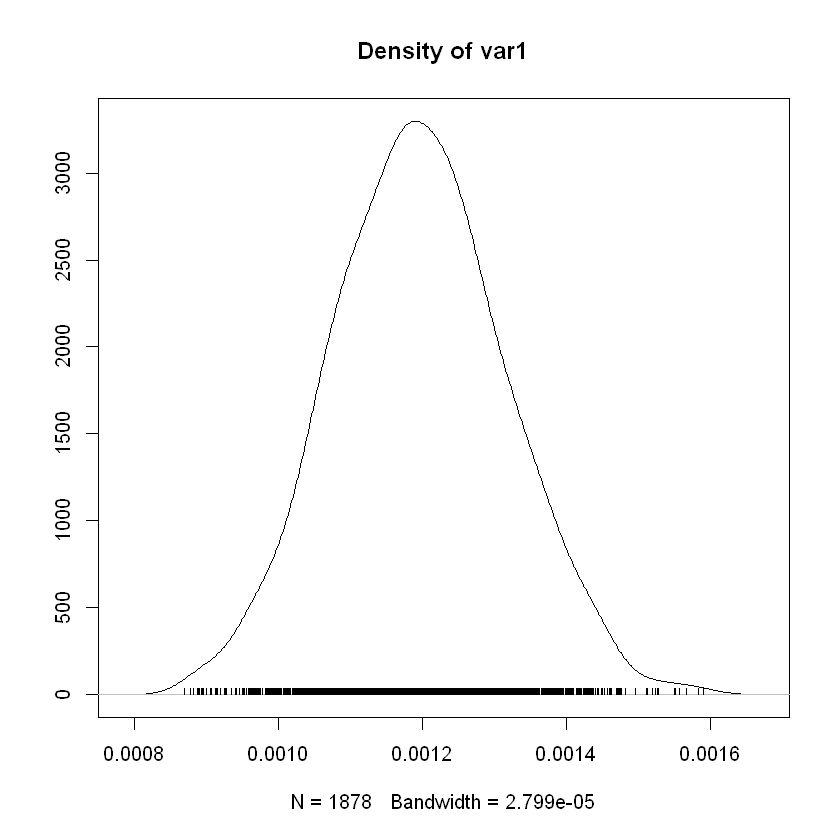

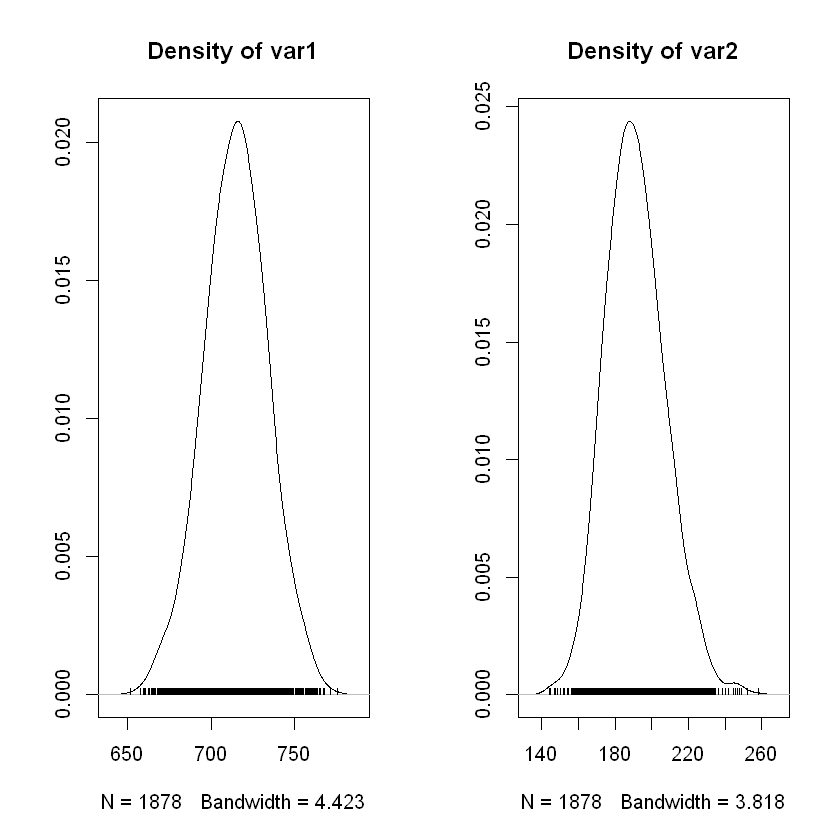

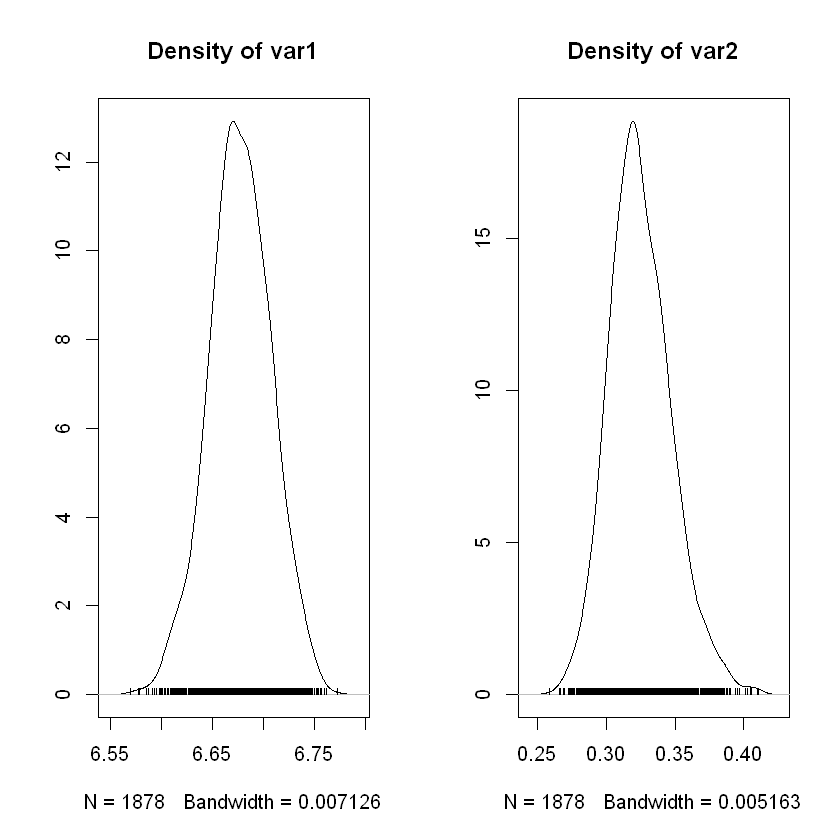

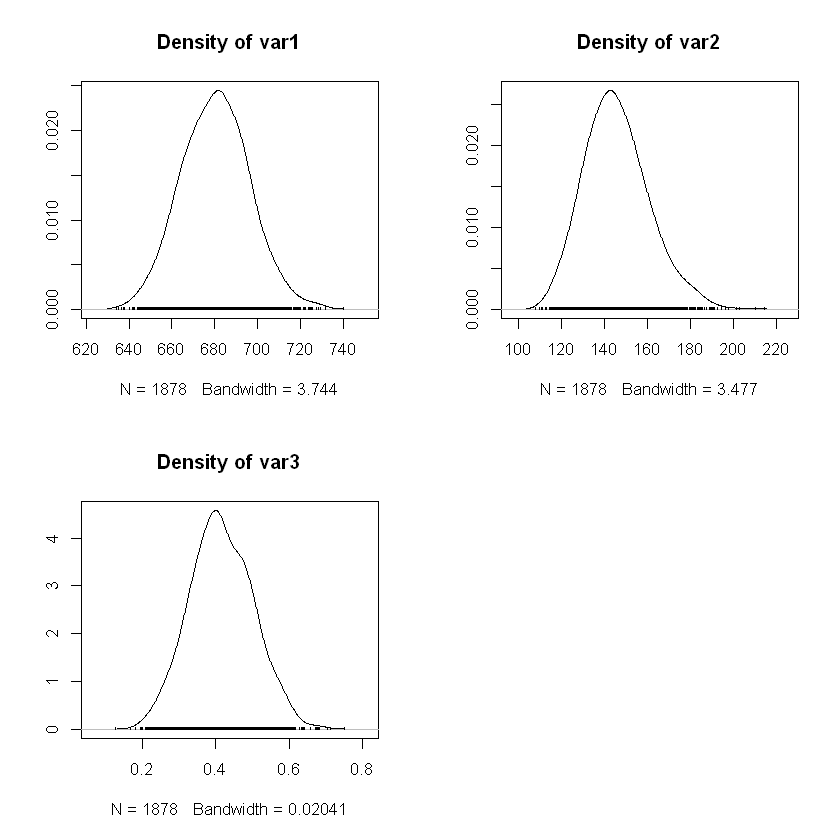

In [184]:
gev.pool = mcmc(rbind(
      mcmc.chains.gev[[1]][seq.int(5000, niter, 40),], 
      mcmc.chains.gev[[2]][seq.int(5000, niter, 40),], 
      mcmc.chains.gev[[3]][seq.int(5000, niter, 40),]))

exp.pool = mcmc(c(
      mcmc.chains.exp[[1]][seq.int(5000, niter, 40),], 
      mcmc.chains.exp[[2]][seq.int(5000, niter, 40),], 
      mcmc.chains.exp[[3]][seq.int(5000, niter, 40),]))

lnorm.pool = mcmc(rbind(
      mcmc.chains.lnorm[[1]][seq.int(5000, niter, 40),], 
      mcmc.chains.lnorm[[2]][seq.int(5000, niter, 40),], 
      mcmc.chains.lnorm[[3]][seq.int(5000, niter, 40),]))

gumbel.pool = mcmc(rbind(
      mcmc.chains.gumbel[[1]][seq.int(5000, niter, 40),], 
      mcmc.chains.gumbel[[2]][seq.int(5000, niter, 40),], 
      mcmc.chains.gumbel[[3]][seq.int(5000, niter, 40),]))

plot(exp.pool, trace=FALSE)

plot(gumbel.pool, trace=FALSE)

plot(lnorm.pool, trace=FALSE)

plot(gev.pool, trace=FALSE)

In [195]:
MaxLp = function(n, mcmc.chains.raw){
    max.lp = (-1/0)
    max.lp.params = 0
    for (i in seq(1, n)){
        lp = max(mcmc.chains.raw[[i]]$log.p)
        j = mcmc.chains.raw[[i]]$samples[which.max(mcmc.chains.raw[[i]]$log.p),]
        if (lp > max.lp){
            max.lp = lp
            max.lp.params = j
        }
    }
    return (max.lp.params)
}


max.gev = MaxLp(3, mcmc.chains.raw.gev)
max.exp = MaxLp(3, mcmc.chains.raw.exp)
max.lnorm = MaxLp(3, mcmc.chains.raw.lnorm)
max.gumbel = MaxLp(3, mcmc.chains.raw.gumbel)

print (max.gev)
print (max.exp)
print (max.lnorm)
print (max.gumbel)

[1] 677.1830683 139.2402608   0.4166009
[1] 0.001186103
[1] 6.6772035 0.3201721
[1] 714.1930 186.7841
